# Experimenting with the IEEE RTS

## Test system

We will now move from the three bus example to the IEEE RTS. You can find a brief description of this system below or visit this <a href="http://www.ee.washington.edu/research/real/Library/Code/UnitCommitmentunderUncertainty-GAMSModels.pdf"><u>link<u></a> for details.

The IEEE RTS system includes 96 generators distributed among 73 buses and connected by 120 lines. The specific characteristics of generators can be found <a href="http://www.ee.washington.edu/research/real/Library/Code/input_UC_ii.xlsx"><u>here</u></a>.

We also added 19 wind farms to the IEEE RTS system, which are characterized as follows:
<img src="http://i62.tinypic.com/23i8d8h.png">


To enlarge the diagram of the IEEE RTS, click on it. 
<a href="http://www.ee.washington.edu/research/real/Library/Data/IEEE-RTS_3_wind_farms.jpg"><img src="http://www.ee.washington.edu/research/real/Library/Data/IEEE-RTS_3_wind_farms.jpg"></a>

## Define packages

In [1]:
using MAT # This package enables reading .mat files
using JuMP 
using Plots
using Interact
gr()

Plots.GRBackend()

## Read data from .mat file

For the following experiments we prepare the input file (ieee_test_system.mat) with all input data needed. In the following simulations we demonstrate how these inputs can be imported directly to Julia. 

In [2]:
file = matopen("ieee_test_system.mat") # open the .mat file with input data
c_g=read(file, "c_g") # incremental costs of generators
c_g0=read(file, "c_g0") # no load costs of generators
g_max=read(file, "g_max") # maximum power outputs of generators
g_min=read(file, "g_min") # minimum power outputs of generators
g_map=read(file, "g_map") # map of generators

d=read(file, "d") # demand

w_f=read(file, "w_f") # wind forecasts for each wind farm
w_map=read(file, "w_map") # map of wind farms

f_map=read(file, "f_map") # map of transmission lines
f_max=read(file, "f_max") #maximum power flow limits of transmission lines 
x=read(file, "x") # reactance of transmission lines
close(file)

N_gen = length(c_g) # number of generators
N_bus = length(d) # number of buses
N_line = length(f_max) # number of lines
N_wind = length(w_f) # number of wind farms


c_w = 10 # dispatch cost of wind generation

10

In [3]:
f_map

120×73 Array{Float64,2}:
 1.0  -1.0   0.0   0.0   0.0   0.0  0.0  …   0.0   0.0   0.0   0.0  0.0   0.0
 1.0   0.0  -1.0   0.0   0.0   0.0  0.0      0.0   0.0   0.0   0.0  0.0   0.0
 1.0   0.0   0.0   0.0  -1.0   0.0  0.0      0.0   0.0   0.0   0.0  0.0   0.0
 0.0   1.0   0.0  -1.0   0.0   0.0  0.0      0.0   0.0   0.0   0.0  0.0   0.0
 0.0   1.0   0.0   0.0   0.0  -1.0  0.0      0.0   0.0   0.0   0.0  0.0   0.0
 0.0   0.0   1.0   0.0   0.0   0.0  0.0  …   0.0   0.0   0.0   0.0  0.0   0.0
 0.0   0.0   1.0   0.0   0.0   0.0  0.0      0.0   0.0   0.0   0.0  0.0   0.0
 0.0   0.0   0.0   1.0   0.0   0.0  0.0      0.0   0.0   0.0   0.0  0.0   0.0
 0.0   0.0   0.0   0.0   1.0   0.0  0.0      0.0   0.0   0.0   0.0  0.0   0.0
 0.0   0.0   0.0   0.0   0.0   1.0  0.0      0.0   0.0   0.0   0.0  0.0   0.0
 0.0   0.0   0.0   0.0   0.0   0.0  1.0  …   0.0   0.0   0.0   0.0  0.0   0.0
 0.0   0.0   0.0   0.0   0.0   0.0  0.0      0.0   0.0   0.0   0.0  0.0   0.0
 0.0   0.0   0.0   0.0   0.0   0.0  0.0

## Economic Dispatch 

The following cell displays the economic dispatch model:

In [4]:
function solve_ed(g_max, g_min, c_g, c_w, d, w_f)
    #Define the economic dispatch (ED) model
    ed = Model() 
    
    # Define decision variables    
    @variable(ed, g_min[i] <= g[i=1:N_gen] <= g_max[i]) # power output of generators
    @variable(ed, 0 <= w  <= w_f ) # wind power injection

    # Define the objective function
    @objective(ed,Min,sum(c_g[i] * g[i] for i=1:N_gen)+ c_w * w)

    # Define the constraint on the wind power injection
    @constraint(ed, w <= w_f)

    # Define the power balance constraint
    @constraint(ed, sum(g[i] for i=1:N_gen) + w == d)

    # Solve statement
    solve(ed)
    # return the optimal value of the objective function and its minimizers
    return getvalue(g), getvalue(w), w_f-getvalue(w), getobjectivevalue(ed)
end


solve_ed (generic function with 1 method)

### Cost and generation dispatch as a function of demand

We use the IEEE RTS system to observe the impact of demand on the total cost and dispatch of individual generators. It can also be observed that different wind generation conditions affect dispatch of generators, even for a fixed demand value.

In [5]:
@manipulate for d = sum(g_min):sum(g_max)
    g_opt,w_opt,ws_opt,obj = solve_ed(g_max, g_min, c_g, c_w, sum(d), sum(w_f))
    HTML("Total cost, \$: $obj")
end

Interact.Slider{Float64}(Signal{Float64}(7152.88, nactions=0),"d",7152.88,4091.88:1.0:10214.880000000001,".3f",true)

HTML{String}("Total cost, \$: 109076.55611200006")

In [6]:
@manipulate for d = sum(g_min):sum(g_max), w_scale = 0.5:0.01:1.5
    g_opt,w_opt,ws_opt,obj = solve_ed(g_max, g_min, c_g, c_w, sum(d), w_scale*sum(w_f))

    #set_default_plot_size(16cm, 10cm)
    
    # Plot dispatch of every generator
    bar(g_opt, xlabel="Generator Index", ylabel="Dispatch, MW",legend=nothing, ylims=(0,400))
end

Interact.Slider{Float64}(Signal{Float64}(7152.88, nactions=0),"d",7152.88,4091.88:1.0:10214.880000000001,".3f",true)

Interact.Slider{Float64}(Signal{Float64}(1.0, nactions=0),"w_scale",1.0,0.5:0.01:1.5,".3f",true)

<?xml version="1.0" encoding="utf-8"?>
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 0 
 
 
 20 
 
 
 40 
 
 
 60 
 
 
 80 
 
 
 0 
 
 
 100 
 
 
 200 
 
 
 300 
 
 
 400 
 
 
 Generator Index 
 
 
 Dispatch, MW

## Unit Commitment

In the following cell we duplicate the UC model presented earlier.

In [7]:
function solve_uc(g_max, g_min, c_g, c_w, d, w_f)
    # Define the unit commitment (UC) model

    uc=Model() 
    
    # Define decision variables    
    @variable(uc, 0 <= g[i=1:N_gen] <= g_max[i]) # power output of generators
    @variable(uc, u[i=1:N_gen], Bin) # Binary status of generators
    @variable(uc, 0 <= w  <= w_f ) # wind power injection

    # Define the objective function
    # try adding fixed operating costs
    @objective(uc,Min,sum(c_g[i] * g[i] for i=1:N_gen)+ c_w * w)

    # Define the constraint on the maximum and minimum power output of each generator
    for i in 1:N_gen
        @constraint(uc,  g[i] <= g_max[i] * u[i]) #maximum
        @constraint(uc,  g[i] >= g_min[i] * u[i]) #minimum
    end


    # Define the constraint on the wind power injection
    @constraint(uc, w <= w_f)

    # Define the power balance constraint
    @constraint(uc, sum(g[i] for i=1:N_gen) + w == d)

    # Solve statement
    status = solve(uc)
    
    return status, getvalue(g), getvalue(w), w_f-getvalue(w), getvalue(u), getobjectivevalue(uc)
end

solve_uc (generic function with 1 method)

### Cost of unit commitment as a function of demand

We can now use the manipulator to gradually adjust the demand and observe its impact on the total cost. Note that the UC model results in a more cost-effective solution than the ED model. 

In [8]:
@manipulate for d = sum(g_min):sum(g_max)
    status,g_opt,w_opt,ws_opt,u_opt,obj = solve_uc(g_max, g_min, c_g, c_w, sum(d), sum(w_f));
    HTML("Total cost, \$: $obj")
end

Interact.Slider{Float64}(Signal{Float64}(7152.88, nactions=0),"d",7152.88,4091.88:1.0:10214.880000000001,".3f",true)

HTML{String}("Total cost, \$: 87889.45125846741")

### Commitment and dispatch of generators as a function of demand

In this experiment, we will adjust the value of demand and wind power forecast to observe their impacts on the commitment and dispatch decisions of generators. Note that these decisions are drastically different from the economic dispatch decisions. 

In [9]:
@manipulate for d = sum(g_min):sum(g_max), w_scale = 0.5:0.01:1.5
    status,g_opt,w_opt,ws_opt,u_opt,obj = solve_uc(g_max, g_min, c_g, c_w, sum(d), w_scale*sum(w_f));

    p1 = bar(g_opt,xlabel="Generator Index", ylabel="Dispatch, MW", legend=nothing)
    p2 = bar(u_opt,xlabel="Generator Index", ylabel="Commitment status", legend=nothing)
    plot(p1,p2)  
end

Interact.Slider{Float64}(Signal{Float64}(7152.88, nactions=0),"d",7152.88,4091.88:1.0:10214.880000000001,".3f",true)

Interact.Slider{Float64}(Signal{Float64}(1.0, nactions=0),"w_scale",1.0,0.5:0.01:1.5,".3f",true)

<?xml version="1.0" encoding="utf-8"?>
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 0 
 
 
 20 
 
 
 40 
 
 
 60 
 
 
 80 
 
 
 0 
 
 
 100 
 
 
 200 
 
 
 300 
 
 
 400 
 
 
 Generator Index 
 
 
 Dispatch, MW 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 0 
 
 
 20 
 
 
 40 
 
 
 60 
 
 
 80 
 
 
 0.0 
 
 
 0.2 
 
 
 0.4 
 
 
 0.6 
 
 
 0.8 
 
 
 1.0 
 
 
 Generator Index 
 
 
 Commitment status

## Optimal Power Flow

In the following cell we present the code for the OPF model:

In [10]:
function solve_dcopf(g_max, g_min, c_g, c_w, d, w_f, g_map, f_map, w_map, f_max, x)
    #Define the optimal power flow (OPF) model

    opf=Model() 
    
    # Define decision variables    
    @variable(opf, g_min[i] <= g[i=1:N_gen] <= g_max[i] ) # power output of generators
    @variable(opf, 0 <= w[v=1:N_wind] <= w_f[v] ) # wind power injection
    @variable(opf, -f_max[l] <= f[l=1:N_line] <= f_max[l]) # power flows 
    @variable(opf, theta[b=1:N_bus]) # bus angle 


    # Define the objective function
    @objective(opf,Min,sum(c_g[i] * g[i] for i=1:N_gen) + sum(c_w * w[v] for v=1:N_wind))

    # Define the power balance constraint
    for b in 1:N_bus
        @constraint(opf, sum(g_map[i,b]* g[i] for i=1:N_gen)  + sum(w_map[v,b] * w[v] for v=1:N_wind)  + sum(f_map[l,b] * f[l] for l=1:N_line)>= d[b]); 
    end

    # Calculate f[l]
    for l in 1:N_line
        @constraint(opf, x[l] * f[l] ==  sum(f_map[l,b] * theta[b] for b=1:N_bus))  # power flow in every line
    end

    # Slack bus 
    @constraint(opf, theta[1] == 0)  # set the slack bus

    #println(opf)

    # Solve statement
    status = solve(opf)
    
    #@show getvalue(theta)

    return status, getobjectivevalue(opf), getvalue(g), getvalue(f), getvalue(w)
end

solve_dcopf (generic function with 1 method)

### Cost of Optimal Power Flow with variable power flow ratings

In the next experiment we use three manipulators, adjusting the power flow limits on transmission lines, demand and wind power generation, to observe their impact on the total cost. 

In [11]:
@manipulate for f_scale = 0.4 : 0.01 : 1.0, d_scale = 0.5:0.01:1.5, w_scale = 0.5:0.01:1.0
    

    status, obj, g_opt, f_opt, w_opt = solve_dcopf(g_max, g_min, c_g, c_w, d_scale*d, w_scale*w_f, g_map, f_map, w_map, f_scale*f_max, x)
   
    HTML("Total cost, \$: $obj")
    
end

Interact.Slider{Float64}(Signal{Float64}(0.7, nactions=0),"f_scale",0.7,0.4:0.01:1.0,".3f",true)

Interact.Slider{Float64}(Signal{Float64}(1.0, nactions=0),"d_scale",1.0,0.5:0.01:1.5,".3f",true)

Interact.Slider{Float64}(Signal{Float64}(0.75, nactions=0),"w_scale",0.75,0.5:0.01:1.0,".3f",true)

HTML{String}("Total cost, \$: 90241.55556063502")

### Dispatch decisions in Optimal Power Flow with variable power flow ratings

Again, we use three manipulators, adjusting the power flow limits on transmission lines, demand and wind power generation, to observe their impact on the the power flows of transmission lines, dispatch decisions of generators and wind power generation. 

In [12]:
@manipulate for f_scale = 0.4 : 0.01 : 1.0, d_scale = 0.5:0.01:1.5, w_scale = 0.5:0.01:1.0
    status, obj, g_opt, f_opt, w_opt = solve_dcopf(g_max, g_min, c_g, c_w, d_scale*d, w_scale*w_f, g_map, f_map, w_map, f_scale*f_max, x)
   
    #set_default_plot_size(16cm, 30cm)
    # Plot dispatch of every generator
    p1 = bar(abs(f_opt), xlabel="Line Index", ylabel="Flow, MW",legend=nothing)
    p2 = bar(g_opt, xlabel="Generator Index", ylabel="Dispatch of generators, MW",legend=nothing,ylims=(0,400))
    p3 = bar(w_opt, xlabel="Wind farm Index", ylabel="Dispatch of wind, MW",legend=nothing,ylims=(0,maximum(w_f)))
    plot(p1,p2,p3)
end

Interact.Slider{Float64}(Signal{Float64}(0.7, nactions=0),"f_scale",0.7,0.4:0.01:1.0,".3f",true)

Interact.Slider{Float64}(Signal{Float64}(1.0, nactions=0),"d_scale",1.0,0.5:0.01:1.5,".3f",true)

Interact.Slider{Float64}(Signal{Float64}(0.75, nactions=0),"w_scale",0.75,0.5:0.01:1.0,".3f",true)

<?xml version="1.0" encoding="utf-8"?>
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 0 
 
 
 50 
 
 
 100 
 
 
 0 
 
 
 50 
 
 
 100 
 
 
 150 
 
 
 200 
 
 
 250 
 
 
 300 
 
 
 350 
 
 
 Line Index 
 
 
 Flow, MW 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 0 
 
 
 20 
 
 
 40 
 
 
 60 
 
 
 80 
 
 
 0 
 
 
 100 
 
 
 200 
 
 
 300 
 
 
 400 
 
 
 Generator Index 
 
 
 Dispatch of generators, MW 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 0 
 
 
 10 
 
 
 20 
 
 
 0 
 
 
 100 
 
 
 200 
 
 
 300 
 
 
 Wind farm Index 
 
 
 Dispatch of wind, MW

### Interactive visualization of power flows

In this section we will show how the power flows can be graphically represented in an interactive fashion. 

In [13]:
using GraphViz # package used for drawing graphs

function writeDot(name, busIdx, busInj, renGen, f, t, lineFlow, lineLim, size=(11,14))
    # This function generates a graph that richly expresses the RTS96 system state.
    # name              a name for the graph and resulting dot file
    # busIdx            bus names (could be text) in order of busInj
    # busInj            injection at each bus
    # renGen            renewable generation at each bus (0 for non-wind buses)
    # f                 "from" node for each line
    # t                 "to" node for each line
    # lineFlow          flow on each line
    # lineLim           limit for each line
    # size              size of graphical output

    busInj = round(busInj,2)
    lineFlow = round(lineFlow,2)
    
    # Open the dot file, overwriting anything already there:
    dotfile = IOBuffer()
    
    # Begin writing the dot file:
    write(dotfile, "digraph $(name) {\nrankdir=LR;\n")

    # Set graph properties:
    write(dotfile, 
    "graph [fontname=helvetica, tooltip=\" \", overlap=false, size=\"$(size[1]),$(size[2])\", ratio=fill, orientation=\"portrait\",layout=dot];\n")

    # Set default node properties:
    write(dotfile, "node [fontname=helvetica, shape=square, style=filled, fontsize=20, color=\"#bdbdbd\"];\n")

    # Set default edge properties:
    write(dotfile, "edge [fontname=helvetica, style=\"setlinewidth(5)\"];\n")

    # Write bus data to dot file:
    for i = 1:length(busIdx)
        write(dotfile, 
        "$(i) [label=$(Int(busIdx[i])), tooltip=\"Inj = $(busInj[i])\"") # bus label and tooltip

        # Represent renewable nodes with blue circles:
        if union(find(renGen),i) == find(renGen)
            write(dotfile, ", shape=circle, color=\"#5677fc\"")
        end

        write(dotfile, "];\n")
    end

    # Write line data to file:

    for i = 1:length(f)

        normStrain = abs(lineFlow[i])/lineLim[i] # normalized strain on line i

        # Use flow direction to determine arrow direction,
        # label with flow,
        # and color according to strain
        #if lineFlow[i] > 0
            write(dotfile, 
            "$(f[i]) -> $(t[i]) [label=$(lineFlow[i])")
        #else
        #    write(dotfile, 
        #    "$(t[i]) -> $(f[i]) [label=$(-lineFlow[i])")
        #end
        write(dotfile,
        ", tooltip=\" \", labeltooltip=\"Flow = $(round(Int,(normStrain*100)))%\", color=\"$(abs(round((1 - normStrain)/3,3))) 1.000 0.700\"];\n")
    end

    write(dotfile, "}\n")

    dottext = takebuf_string(dotfile)
    #print(dottext)

    return Graph(dottext)
end

writeDot (generic function with 2 methods)

Interact.Slider{Float64}(Signal{Float64}(0.7, nactions=0),"f_scale",0.7,0.4:0.01:1.0,".3f",true)

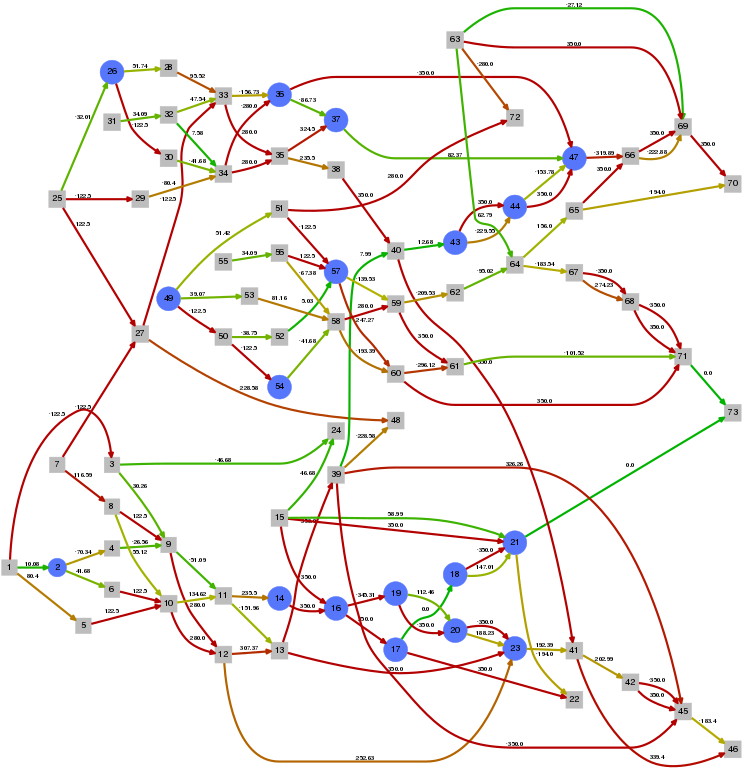

In [15]:
# We need to reformat the input data
from_node = [find(f_map[i,:] .== 1)[1] for i in 1:size(f_map,1)];
to_node = [find(f_map[i,:] .== -1)[1] for i in 1:size(f_map,1)];


@manipulate for f_scale = 0.4 : 0.01 : 1.0
    status, obj, g_opt, f_opt, w_opt = solve_dcopf(g_max, g_min, c_g, c_w, d, w_f, g_map, f_map, w_map, f_scale*f_max, x)
    
    wind_bus = zeros(N_bus)
    for i in 1:N_wind
        wind_idx = find(w_map[i,:] .== 1)[1]
        wind_bus[wind_idx] = f_opt[i]
    end
    
    writeDot("OPF", collect(1:N_bus), g_opt, wind_bus, from_node, to_node, f_opt, f_scale*f_max, (8,8))

end